## Sampling distributions

In this notebook we will use the NHANES data to explore the sampling distributions of statistics.  This is a somewhat more conceptual topic than we have encountered before when working with the NHANES data.  Some of the illustrations covered below are not things that would typically be done in a data analysis, but rather are intended to clarify some important concepts about statistical methods.  However even these methods have their uses in practice, for example the approaches demostrated below can be used to demonstrate how a statistic behaves in a "nonstandard" setting, or to assess how much data is needed to answer a question confidently.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In the cell below, we read the data from a local file:

In [2]:
da = pd.read_csv("nhanes_2015_2016.csv")

### Sampling distribution of the mean

Sampling distributions describe how the value of a statistic computed from data varies when repeated samples of data are obtained.  This can be explored mathematically, or by using a computer to simulate data repeatedly from a hypothetical population.  When working with non-simulated data (i.e. from a study like NHANES), we usually do not have the ability to explicitly obtain an "independent copy" of the sample to actually "see" its sampling distribution.  However we can "subsample" from a dataset to mimic what would happen if we were to sample repeatedly from the population that produced it.  A subsample is a random sample drawn from a larger data set, containing only a fraction of its observations.

In the notebook cell below, we repeatedly subsample two disjoint subsets of size 100 from the NHANES data, calculate the mean systolic blood pressure within each of these two subsets, then calculate the difference between these two means.  This difference reflects the "chance variation" that would have been observed if the NHANES project had only had the resources to sample 100 participants for their study.  By sampling two subsets of size 100 and comparing the resulting calculated means, we can see how the findings of two researchers independently studying the same population might differ from each other by chance.  

The subsampling process described above is then repeated 1000 times, so we can see how two samples of size 100 from the NHANES population tend to differ in terms of their mean systolic blood pressure.


In [3]:
m = 100 # Subsample size
sbp_diff = [] # Storage for our subsample mean differences

for i in range(1000):
    dx = da.sample(2*m)  # We need two subsamples of size m
    dx1 = dx.iloc[0:m, :]  # First subsample
    dx2 = dx.iloc[m:, :]  # Second subsample
    sbp_diff.append(dx1.BPXSY1.mean() - dx2.BPXSY1.mean())  # The difference of mean BPXSY1 values

Next we look at the histogram of the 1000 mean differences generated above.  We see that they typically fall between negative 5 and positive 5.  This means that two researchers independently studying blood pressure in the same population may by chance obtain results that are up to around 5 units different, but are quite unlikely to obtain results that are by chance more than 10 units different.

<AxesSubplot:ylabel='Count'>

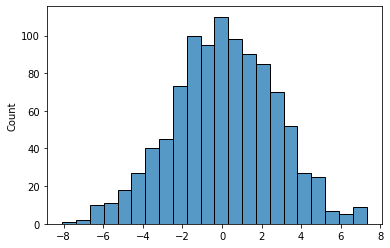

In [4]:
sns.histplot(sbp_diff)

In the cell below, we look at some numerical statistics of the histogram plotted above.

In [5]:
pd.Series(sbp_diff).describe()

count    1000.000000
mean        0.125750
std         2.606077
min        -8.069956
25%        -1.642113
50%         0.153240
75%         1.919253
max         7.309397
dtype: float64

The results shown above indicate that the mean systolic blood pressures calculated for two samples each with 100 people will typically differ by around 2.8 mm/Hg (the standard deviation), and will rarely differ by more than 5 mm/Hg.

The sample size is a major determinant of the chance fluctuations in any statistic.  Above we used samples of size 100, below we perform the same analysis using samples of size 400. 

count    1000.000000
mean        0.013028
std         1.345262
min        -4.938125
25%        -0.899705
50%         0.027928
75%         0.991827
max         3.937290
dtype: float64

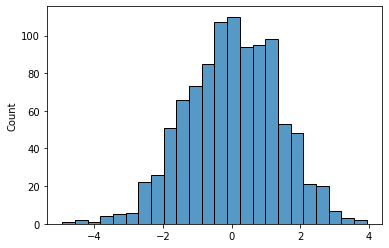

In [8]:
m = 400  # Change the sample size, everything else below is unchanged from the cells above
sbp_diff = []

for i in range(1000):
    dx = da.sample(2*m)
    dx1 = dx.iloc[0:m, :]
    dx2 = dx.iloc[m:, :]
    sbp_diff.append(dx1.BPXSY1.mean() - dx2.BPXSY1.mean())
    
sns.histplot(sbp_diff)
pd.Series(sbp_diff).describe()

We see that with samples of size 400, the standard deviation is around 1.38, which is close to half of what it was when we used samples of size 100.  The smaller standard deviation indicates that the chance flucatations in the mean systolic blood pressure are smaller when we have a larger sample size.  This implies that we are able to estimate the population mean systolic blood pressure with more precision when we have samples of size 400 compared to when we have samples of size 100.

Importantly, increasing the sample size by a factor of 4 (from 100 to 400) led to a reduction of the standard deviation by a factor of 2.  This scaling behavior is very common in statistics -- increasing the sample size by a factor of K leads to a reduction in the standard deviation by a factor of sqrt(K).  Thus, for a factor of 4 increase in the sample size we see a factor of 2 reduction in standard deviation.  Similarly, for a factor of 9 increase in the sample size we would typically see a factor of 3 reduction in the standard deviation.

### Sampling distribution of the correlation coefficient

As discussed in the lectures, many statistics that are more complex than the sample mean behave similarly to the mean in terms of their sampling behavior.  Below we modify the subsampling analysis from above to consider the Pearson correlation coefficient between systolic and diastolic blood pressure.  Note that the standard deviation still drops by approximately a factor of 2 when the sample size increases by a factor of four (from 100 to 400).

This short Python program uses nested `for` loops.  The outer loop manages the sample size, and the inner loop obtains 1000 subsamples at a given sample size, calculates correlation coefficients for two subsamples, and records their difference.

In [9]:
for m in 100, 400:  # m is the subsample size
    sbp_diff = [] # calculate correlation coefficients from independent samples of size m
    for i in range(1000):
        dx = da.sample(2*m)
        dx1 = dx.iloc[0:m, :]
        dx2 = dx.iloc[m:, :]
        r1 = np.corrcoef(dx1.loc[:, ["BPXSY1", "BPXDI1"]].dropna().T)
        r2 = np.corrcoef(dx2.loc[:, ["BPXSY1", "BPXDI1"]].dropna().T)
        sbp_diff.append(r1 - r2)
    print("m=%d" % m, np.std(sbp_diff), np.sqrt(2 / m))    

m=100 0.1261908924572688 0.1414213562373095
m=400 0.06327807869161775 0.07071067811865475


The simulation above shows that when the subsample size increases from 100 to 400 (a factor of 4), the standard deviation of the difference between two correlation coefficients decreases by roughly a factor of 2.  The mathematical expression sqrt(2 / m) is an approximation to this standard deviation that can be computed without access to any data. 

### The shape of sampling distributions

Above we focused on the magnitude of the difference between a statistic calculated on two independent samples from a population.  Here we focus instead on the shape of the distribution of statistics calculated on subsamples.  As discussed in the lectures, the central limit theorem implies that many (but not all) statistics have approximately normal sampling distributions, even if the underlying data are not close to being normally distributed.

We will illustrate this phenomenon using the systolic blood pressure data from the NHANES study.  First we use a histogram to look at the distribution of individual systolic blood pressure values.  Note that it is somewhat right-skewed.

<AxesSubplot:xlabel='BPXSY1', ylabel='Count'>

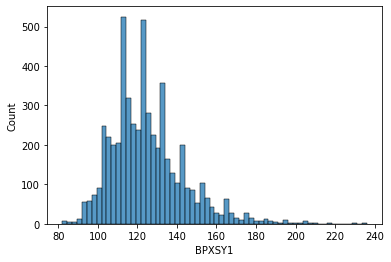

In [11]:
sns.histplot(da.BPXSY1.dropna())

Next we calculate 1000 sample means from 1000 subsamples of size 50 and inspect their distribution.

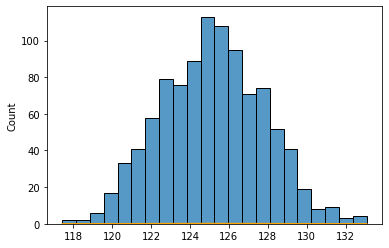

In [12]:
m = 50
sbp_mean = []
for i in range(1000):
    dx = da.sample(m)
    sbp_mean.append(dx.BPXSY1.dropna().mean())
sns.histplot(sbp_mean)

# The lines below plot the density of a normal approximation to the data generated above
x = np.linspace(np.min(sbp_mean), np.max(sbp_mean), 100)
from scipy.stats.distributions import norm
y = norm.pdf(x, np.mean(sbp_mean), np.std(sbp_mean))
plt.plot(x, y, color='orange')

The plots above show that while the distribution of individual systolic blood pressure measures is somewhat skewed to the right, the distribution of means of size 50 is approximately symmetric.  The distribution of means is also approximately normal, as shown by the orange curve, which is the best-fitting normal approximation to the data.